<a href="https://colab.research.google.com/github/nicolas1805961/Deep-learning/blob/main/tp1_dlim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import zipfile
import os

with zipfile.ZipFile('/content/drive/My Drive/iSeg-2017-Training.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train/')

with zipfile.ZipFile('/content/drive/My Drive/iSeg-2017-Testing.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/test/')

In [90]:
import zipfile
import os

def get_file_list(folder):

  T1_paths = sorted([os.path.join(os.getcwd(), folder, x) for x in os.listdir(folder) if 'T1' in x and 'img' in x], key=lambda x: int(x.split('-')[1]))
  T2_paths = sorted([os.path.join(os.getcwd(), folder, x) for x in os.listdir(folder) if 'T2' in x and 'img' in x], key=lambda x: int(x.split('-')[1]))
  label_paths = sorted([os.path.join(os.getcwd(), folder, x) for x in os.listdir(folder) if 'label' in x and 'img' in x], key=lambda x: int(x.split('-')[1]))

  print(T1_paths)

  T1_files_list = [np.squeeze(nib.load(filepath).get_fdata(), -1) for filepath in T1_paths]
  T2_files_list = [np.squeeze(nib.load(filepath).get_fdata(), -1) for filepath in T2_paths]
  label_files_list = [np.squeeze(nib.load(filepath).get_fdata(), -1) for filepath in label_paths]

  return T1_files_list, T2_files_list, label_files_list

In [77]:
def process_data(T1_files_list, T2_files_list, label_files_list, max_value):

  T1_train = np.swapaxes(np.concatenate(T1_files_list, axis=-1), 0, 2)
  T2_train = np.swapaxes(np.concatenate(T2_files_list, axis=-1), 0, 2)
  Y_train = np.swapaxes(np.concatenate(label_files_list, axis=-1), 0, 2)

  mask = np.any(Y_train, axis=(1, 2))
  Y_train = Y_train[mask].astype(np.uint16)
  T1_train = T1_train[mask]
  T2_train = T2_train[mask]

  X_train = np.stack([T1_train, T2_train], axis=-1)
  X_train /= max_value

  Y_train = np.select([Y_train == 0, Y_train == 10, Y_train == 150, Y_train == 250], [0, 1, 2, 3])

  return X_train, Y_train

In [80]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def process_train_data(T1_files_list, T2_files_list, label_files_list):

  max_value = max(np.amax(T1_files_list), np.amax(T2_files_list))
  val_index = np.random.randint(0, 10, 2)
  T1_val_files = [T1_files_list.pop(i) for i in val_index]
  T2_val_files = [T2_files_list.pop(i) for i in val_index]
  Y_val_files = [label_files_list.pop(i) for i in val_index]

  X_train, Y_train = process_data(T1_files_list, T2_files_list, label_files_list, max_value)
  X_val, Y_val = process_data(T1_val_files, T2_val_files, Y_val_files, max_value)

  return X_train, Y_train, X_val, Y_val

In [81]:
T1_files_list, T2_files_list, label_files_list = get_file_list('train')
X_train, Y_train, X_val, Y_val = process_train_data(T1_files_list, T2_files_list, label_files_list)

In [82]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(np.unique(X_train))
print(np.unique(Y_train))
print(np.unique(X_val))
print(np.unique(Y_val))

(810, 192, 144, 2)
(810, 192, 144)
(200, 192, 144, 2)
(200, 192, 144)
[0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011
 0.012 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023
 0.024 0.025 0.026 0.027 0.028 0.029 0.03  0.031 0.032 0.033 0.034 0.035
 0.036 0.037 0.038 0.039 0.04  0.041 0.042 0.043 0.044 0.045 0.046 0.047
 0.048 0.049 0.05  0.051 0.052 0.053 0.054 0.055 0.056 0.057 0.058 0.059
 0.06  0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07  0.071
 0.072 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08  0.081 0.082 0.083
 0.084 0.085 0.086 0.087 0.088 0.089 0.09  0.091 0.092 0.093 0.094 0.095
 0.096 0.097 0.098 0.099 0.1   0.101 0.102 0.103 0.104 0.105 0.106 0.107
 0.108 0.109 0.11  0.111 0.112 0.113 0.114 0.115 0.116 0.117 0.118 0.119
 0.12  0.121 0.122 0.123 0.124 0.125 0.126 0.127 0.128 0.129 0.13  0.131
 0.132 0.133 0.134 0.135 0.136 0.137 0.138 0.139 0.14  0.141 0.142 0.143
 0.144 0.145 0.146 0.147 0.148 0.149 0.15  0.151 0.152

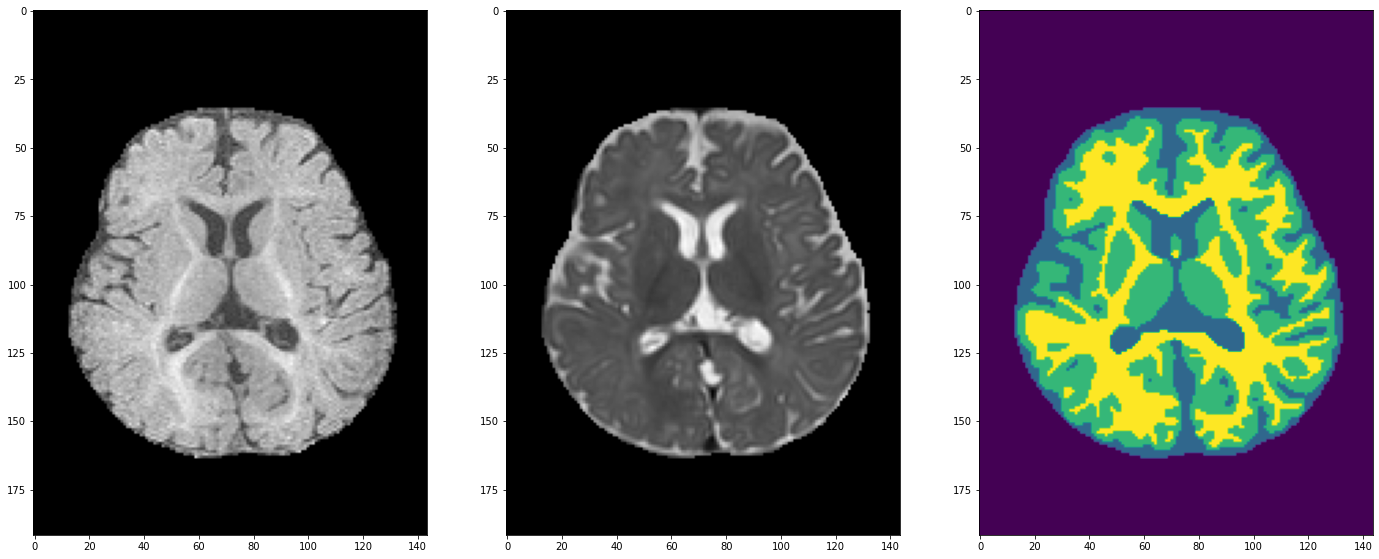

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(24, 10))
ax[0].imshow(X_train[256, ..., 0], cmap='gray')
ax[1].imshow(X_train[256, ..., 1], cmap='gray')
ax[2].imshow(Y_train[256])

In [84]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class Data_generator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, X, Y):
        self.batch_size = batch_size
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        batch_x = self.X[idx * self.batch_size : idx * self.batch_size + self.batch_size]
        batch_y = self.Y[idx * self.batch_size : idx * self.batch_size + self.batch_size]
        return batch_x, batch_y

# Instantiate data Sequences for each split
batch_size = 32
train_gen = Data_generator(batch_size, X_train, Y_train)
val_gen = Data_generator(batch_size, X_val, Y_val)

In [85]:
def get_model():
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((192, 144, 2))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(4, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [8]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [8, 4]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(4, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 144, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 72, 4)    76          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 72, 4)    16          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 72, 4)    0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [86]:
from keras import optimizers

adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=adam, metrics=['accuracy'], loss="sparse_categorical_crossentropy")

# Train the model, doing validation at the end of each epoch.
model.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
25/25 [==============================] - 35s 1s/step - loss: 2.0488 - accuracy: 0.3024 - val_loss: 1.3588 - val_accuracy: 0.0584
Epoch 2/15
25/25 [==============================] - 35s 1s/step - loss: 1.7822 - accuracy: 0.5004 - val_loss: 1.3529 - val_accuracy: 0.0387
Epoch 3/15
25/25 [==============================] - 35s 1s/step - loss: 1.5922 - accuracy: 0.5494 - val_loss: 1.3829 - val_accuracy: 0.0415
Epoch 4/15
25/25 [==============================] - 35s 1s/step - loss: 1.4363 - accuracy: 0.5824 - val_loss: 1.3792 - val_accuracy: 0.0461
Epoch 5/15
25/25 [==============================] - 35s 1s/step - loss: 1.3009 - accuracy: 0.6092 - val_loss: 1.3422 - val_accuracy: 0.0417
Epoch 6/15
25/25 [==============================] - 35s 1s/step - loss: 1.1828 - accuracy: 0.6374 - val_loss: 1.2936 - val_accuracy: 0.0474
Epoch 7/15
25/25 [==============================] - 35s 1s/step - loss: 1.0770 - accuracy: 0.6604 - val_loss: 1.2281 - val_accuracy: 0.4483
Epoch 8/15
25/25 [==

In [91]:
T1_files_list, T2_files_list, label_files_list = get_file_list('test')
max_value = max(np.amax(T1_val_files), np.amax(T2_val_files))
X_test, Y_test = process_data(T1_files_list, T2_files_list, label_files_list, max_value)
print(X_test.shape)
print(Y_test.shape)

['/content/test/subject-11-T1.img', '/content/test/subject-12-T1.img', '/content/test/subject-13-T1.img', '/content/test/subject-14-T1.img', '/content/test/subject-15-T1.img', '/content/test/subject-16-T1.img', '/content/test/subject-17-T1.img', '/content/test/subject-18-T1.img', '/content/test/subject-19-T1.img', '/content/test/subject-20-T1.img', '/content/test/subject-21-T1.img', '/content/test/subject-22-T1.img', '/content/test/subject-23-T1.img']


ValueError: ignored

In [89]:
for array in T1_files_list:
  print(array.shape)

(144, 192, 256)
(144, 192, 256)
(144, 192, 256)
(144, 192, 256)
(144, 192, 256)
(144, 192, 256)
(144, 192, 256)
(144, 192, 256)
(144, 192, 256)
(144, 192, 256)
(144, 192, 256)
(144, 192, 256)
(160, 192, 256)
